In [142]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import asyncio
import xgboost
from sklearn import model_selection
from scipy.spatial.distance import euclidean, pdist, cdist, squareform
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import preprocessing, metrics, linear_model, multiclass, feature_selection, pipeline
from dataclasses import make_dataclass
from server import models, config
from server.kalman import KalmanRSSI
import imblearn
import seaborn

# Грузим исиходные данные
Иммется таблица сигналов, поступивших со сканеров, расположенных по дому (по одному или несколько сканеров на помещение). Каждый объект сигнала содержит:
1. Нзвание сканера, с которого получены данные
2. Название помещения, в котором находилось отслеживаемое устройство в момент получения сигнала
3. Уровень сообщенного сканером сигнала до устройства, также есть значение отфильтрованного фильтром Калмана сигнала, которое является менее шумным (данный факт продемонстрирован далее на графиках)
4. Дата и время получения сигнала

Данные для каждого помещения собирались непрерывно, НО для некоторых помещений сборка была разделена на несколько сессий (сегодня пол часика пособрила, закончил, завтра пол часика пособирал, закончил)

In [2]:
await models.init_db({ 'config': config })

In [3]:
device = await models.Device.get(name='Mi Smart Band 6')
raw_all_signals = await models.DeviceSignal.filter(device=device).prefetch_related(
    'room', 'scanner', 'learning_session')

# Анаилизируем входные данные, баланс классов

In [4]:
Signal_dc = make_dataclass('Signal', [("id", int), ("room", str), ("scanner", str), ("rssi", float), ("when", int), ("training_session", int)])
signals_df = pd.DataFrame([Signal_dc(
    id=s.id,
    room=s.room.name,
    scanner=s.scanner.uuid,
    rssi=s.rssi,
    when=s.created_at.timestamp(),
    training_session=s.learning_session.id,
) for s in raw_all_signals])

signals_df.set_index('id')
signals_df['room'] = signals_df['room'].astype("category")
signals_df['scanner'] = signals_df['scanner'].astype("category")
signals_df['training_session'] = signals_df['training_session'].astype("category")
signals_df.sort_values(by=['when'])

,id,room,scanner,rssi,when,training_session
0,33713,Office,bathroom,-86.0,1.623175e+09,8
1,33714,Office,office,-72.0,1.623175e+09,8
2,33715,Office,office,-72.0,1.623175e+09,8
3,33716,Office,office,-72.0,1.623175e+09,8
4,33717,Office,bathroom,-81.0,1.623175e+09,8
...,...,...,...,...,...,...
7026,41227,Office,bathroom,-69.0,1.623314e+09,9
7027,41228,Office,office,-91.0,1.623314e+09,9
7028,41229,Office,lobby,-84.0,1.623314e+09,9
7029,41230,Office,bathroom,-70.0,1.623314e+09,9


In [5]:
signals_df['training_session'].value_counts()

4    2451
5    1256
8     818
9     703
7     536
3     404
1     381
2     244
6     238
Name: training_session, dtype: int64

In [6]:
for ts in signals_df['training_session'].cat.categories:
    for scanner in signals_df['scanner'].cat.categories:
        mask = (signals_df['training_session'] == ts) & (signals_df['scanner'] == scanner)
        signals_df.loc[mask, 'delay'] = signals_df.loc[mask, 'when'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

signals_df['delay'].fillna(0, inplace=True)

In [7]:
signals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7031 entries, 0 to 7030
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                7031 non-null   int64   
 1   room              7031 non-null   category
 2   scanner           7031 non-null   category
 3   rssi              7031 non-null   float64 
 4   when              7031 non-null   float64 
 5   training_session  7031 non-null   category
 6   delay             7031 non-null   float64 
dtypes: category(3), float64(3), int64(1)
memory usage: 241.5 KB


In [8]:
signals_df.describe()

,id,rssi,when,delay
count,7031.000000,7031.000000,7.031000e+03,7031.000000
mean,37508.403925,-79.805860,1.623253e+09,11.195670
std,2239.909033,7.441818,6.437516e+04,43.953648
min,33713.000000,-97.000000,1.623175e+09,0.000000
25%,35470.500000,-86.000000,1.623179e+09,1.664611
50%,37716.000000,-80.000000,1.623305e+09,5.403427
75%,39473.500000,-75.000000,1.623308e+09,10.567647
max,41231.000000,-53.000000,1.623314e+09,1803.442518


In [9]:
signals_df['room'].value_counts()

Guest       2451
Office      1521
Kitchen     1256
Bathroom     625
Lobby        536
Bedroom      404
Laundry      238
Name: room, dtype: int64

In [10]:
signals_df['scanner'].value_counts()

guest       1281
laundry     1119
kitchen      998
bathroom     947
office       857
lobby        786
extra-1      762
bedroom      281
Name: scanner, dtype: int64

## Изменчивость по комнатам
1. Как меняется распределение данных с сенсоров в зависимости от комнаты?
2. Как соотоносятся друг с другом данные с сенсоров в зависимостиот комнаты?

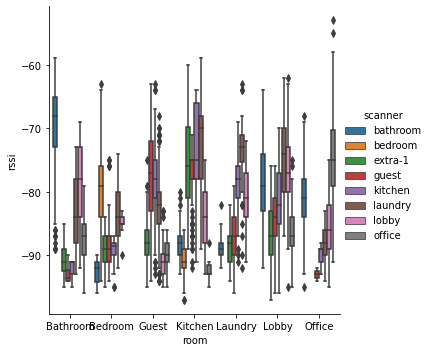

In [11]:
seaborn.catplot(x="room", y="rssi", hue="scanner", kind="box",
    data=signals_df)

## Анализ частоты поступления обновлений со сканеров
1. Как часто поступают обновленные значения со сканеров в зависимости от помещения?
2. Как зависит частота от уровня сигнала?

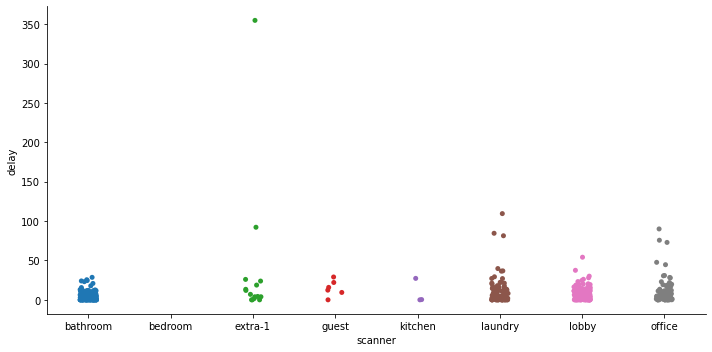

In [12]:
seaborn.catplot(x="scanner", y="delay",
    aspect=2, data=signals_df[signals_df['room'] == 'Bathroom'])

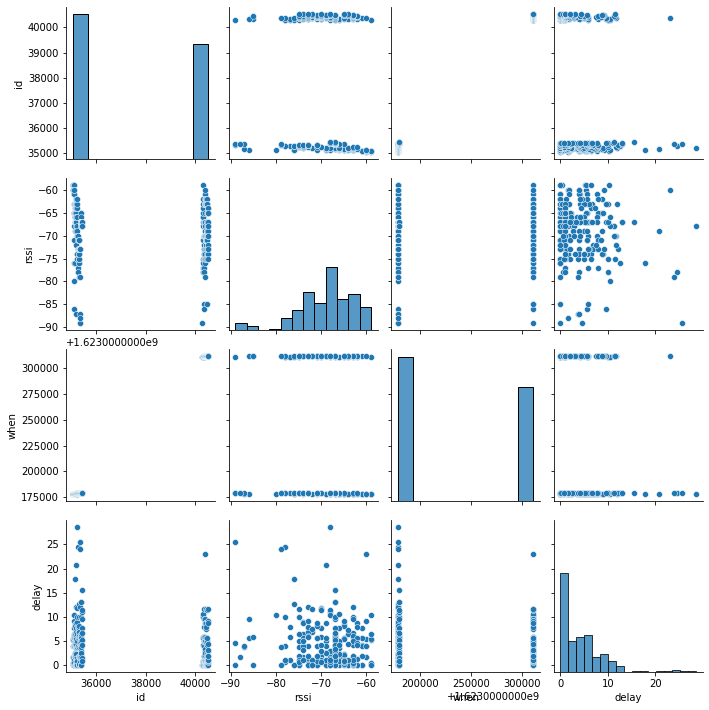

In [13]:
seaborn.pairplot(signals_df[(signals_df['room'] == 'Bathroom') & (signals_df['scanner'] == 'bathroom')])

In [14]:
print('Статистики "delay" по самому близкому сканеру в помещении')
signals_df[(signals_df['room'] == 'Bathroom') & (signals_df['scanner'] == 'bathroom')]['delay'].describe()

Статистики "delay" по самому близкому сканеру в помещении


count    249.000000
mean       4.354203
std        4.856253
min        0.000000
25%        0.792109
50%        3.292044
75%        6.095287
max       28.560036
Name: delay, dtype: float64

In [15]:
signals_df['rssi_bin'] = pd.cut(signals_df['rssi'], [-np.inf] + list(range(-100, -30, 5)) + [np.inf])
signals_df[['rssi', 'delay', 'rssi_bin']][signals_df['delay'] > 0].groupby('rssi_bin').agg({'rssi': 'mean', 'delay': ['mean', 'median', 'std', 'min', 'max'], 'rssi_bin': 'count'})

rssi      delay                                   \
                      mean       mean     median         std       min   
rssi_bin                                                                 
(-inf, -100.0]         NaN        NaN        NaN         NaN       NaN   
(-100.0, -95.0] -95.343750  51.505269  15.939550   89.996464  0.001297   
(-95.0, -90.0]  -91.259375  31.672786   7.971141  121.713183  0.000303   
(-90.0, -85.0]  -87.050000  13.040621   5.835126   39.778504  0.000285   
(-85.0, -80.0]  -81.810692  10.828854   5.744555   24.496197  0.000308   
(-80.0, -75.0]  -77.028238   7.087730   4.811084   10.904379  0.000278   
(-75.0, -70.0]  -72.129630   6.273657   4.686865    7.642963  0.000295   
(-70.0, -65.0]  -67.290389   5.062971   3.851573    6.955610  0.000299   
(-65.0, -60.0]  -62.974684   5.126654   3.839471    8.080254  0.000302   
(-60.0, -55.0]  -58.500000   5.388545   5.255835    5.603700  0.000352   
(-55.0, -50.0]  -53.000000   0.885981   0.885981         NaN  0.885981   
(-50.0, -45.0]         NaN        NaN        NaN         NaN       NaN   
(-45.0, -40.0]         NaN        NaN        NaN         NaN       NaN   
(-40.0, -35.0]         NaN        NaN        NaN         NaN       NaN   
(-35.0, inf]           NaN        NaN        NaN         NaN       NaN   

                             rssi_bin  
                         max    count  
rssi_bin                               
(-inf, -100.0]           NaN        0  
(-100.0, -95.0]   354.846889       32  
(-95.0, -90.0]   1803.442518      640  
(-90.0, -85.0]   1239.942290     1400  
(-85.0, -80.0]    548.885105     1590  
(-80.0, -75.0]    187.666174     1629  
(-75.0, -70.0]    108.845816     1026  
(-70.0, -65.0]    101.257171      489  
(-65.0, -60.0]     80.978056      158  
(-60.0, -55.0]     18.294001       10  
(-55.0, -50.0]      0.885981        1  
(-50.0, -45.0]           NaN        0  
(-45.0, -40.0]           NaN        0  
(-40.0, -35.0]           NaN        0  
(-35.0, inf]             NaN        0

## Выводы
1. Чем меньше RSSI (ниже уровень сигнала), тем больше в среднем задержка между новыми значениями сигнала.
2. В среднем частота поступления сигналов от ближайших сканеров около 7 секунд
3. Частота поступления сигнала от дальних сканеров не менее 15 секунд
4. Частота поступления сигналов может сильно варьироваться даже с близких сканеров. При этом чем хуже сигнал, тем больше вариативность (стандартное отклонение)

# Моделирование heartbeats и аналализ параметров
Каждые N секунд классификатор должен принимать решение о нахождении устройства в том или ином помещении. Для этого он должен использовать всю доступную информацию, а именно:
1. Известные на данный момент значения со всех сканеров
2. "Свежесть" значения с каждого сканера (если с некоторого сканера давно не было сигнала, то возможно усйтройство ушло из поля зрения сканера)

Если с получением значений все более или мение ясно (хотя возможно имеет смысл уменьшать зашумленность за счет фильтра калмана, нужно подбирать параметры фильтра), то со "свежестью" есть несколько идей, нуждающихся в проверке:
1. Добавить признак для каждого сканера, значение которого будет равняться количеству секунд, прошедших с момента поступления сигнала со сканера до текущего момента определения положения.
2. На каждой итерации снятия показаний уменьшать известный уровень сигнала со сканеров, которые за период между итерациями не получали обновлений, на некоторое число (penalty). Таким образом уровень сигнала будет постепенно сводиться к "отсутствующему" сигналу. Здесь нужно подбирать способ выбора penalty (константа, функция от времени/итерации)
3. Занулять уровень сигнала со сканеров, которые не обновлялись последние M итераций. 
4. Некоторая комбинация из способов выше

In [144]:
class HeratbeatGenerator:
    def __init__(self, scanners=None, kalman=None, penalty=None, off_on_delay=None) -> None:
        scanners = scanners or []
        self.values = dict(zip(scanners, [-100] * len(scanners)))
        self.delay = dict(zip(scanners, [0] * len(scanners)))
        self.last_time = dict(zip(scanners, [0] * len(scanners)))
        self.appeared = dict(zip(scanners, [False] * len(scanners)))
        self.penalty = penalty
        self.off_on_delay = off_on_delay
        self.filters = {} if kalman is not None else None
        self.kalman = kalman

    def process(self, signals, time, period):
        silent_scanners = set(self.values.keys())

        for s in signals:
            scanner = s['scanner']
            if self.kalman:
                if scanner not in self.filters:
                    self.filters[scanner] = KalmanRSSI(R=self.kalman[0], Q=self.kalman[1])
                self.values[scanner] = self.filters[scanner].filter(s['rssi'])
            else:
                self.values[scanner] = s['rssi']

            self.appeared[scanner] = True
            self.last_time[scanner] = s['when']

            silent_scanners -= set([scanner])

        for scanner in self.values.keys():
            if self.appeared.get(scanner, False):
                self.delay[scanner] = time - self.last_time[scanner]
            else:
                self.delay[scanner] += period

        if self.penalty is not None and self.penalty > 0:
            for scanner in silent_scanners:
                if self.values[scanner] > -100:
                    self.values[scanner] -= self.penalty
                    self.values[scanner] = max(self.values[scanner], -100)
                if self.kalman and scanner in self.filters and scanner in self.values:
                    self.filters[scanner].filter(self.values[scanner])

        if self.off_on_delay is not None and self.off_on_delay > 0:
            for scanner in silent_scanners:
                if self.delay[scanner] >= self.off_on_delay and self.values[scanner] > -100:
                    self.values[scanner] = -100
                if self.kalman and scanner in self.filters and scanner in self.values:
                    self.filters[scanner].filter(self.values[scanner])

        return self.create_heartbeat(signals, time)

    def create_heartbeat(self, signals, time):
        return dict(self.values)

class DelayFeatureHeratbeatGenerator(HeratbeatGenerator):
    def create_heartbeat(self, signals, time):
        result = super().create_heartbeat(signals, time)
        for scanner in self.values.keys():
            result['{}_delay'.format(scanner)] = self.delay[scanner]
        return result

def generate_heartbeats(period=10, gen='simple', kalman_R=None, kalman_Q=None, penalty=None, off_on_delay=None, skip_first=30):
    data = []
    kalman = (kalman_R, kalman_Q) if kalman_R is not None and kalman_Q is not None else None
    scanners = list(signals_df['scanner'].value_counts().index)
    generators = {
        'simple': HeratbeatGenerator,
        'delay-feature': DelayFeatureHeratbeatGenerator,
    }

    for room in signals_df['room'].cat.categories:
        print('Room ', room)
        generator = generators[gen](scanners, kalman=kalman, penalty=penalty, off_on_delay=off_on_delay)
        room_mask = signals_df['room'] == room
        room_sessions = signals_df.loc[room_mask]['training_session'].value_counts()
        to_skip = skip_first

        for session, count in room_sessions.iteritems():
            if count <= 0: continue

            session_mask = room_mask & (signals_df['training_session'] == session)
            session_df = signals_df.loc[session_mask, :]
            start_time = session_df['when'].min()
            end_time = session_df['when'].max()

            for curr_time in range(int(start_time + period - 1), int(end_time + period), period):
                frame_mask = (session_df['when'] > (curr_time - period)) & (session_df['when'] <= curr_time)
                frame_signals = (s for _, s in session_df.loc[frame_mask].iterrows())
                heartbeat = generator.process(frame_signals, curr_time, period)
                heartbeat['room'] = room

                if to_skip <= 0:
                    data.append(heartbeat)
                else:
                    to_skip -= period

    result_df = pd.DataFrame(data)
    result_df.drop_duplicates(inplace=True)
    return result_df

## Метрика качества
1 (positive) - устройство в помещении, 0 (negative) - устройства нет в помещении.

Больше всего нехочется, чтобы свет выключался, когда в помещении присутствуюет устройство. Иначе говоря, при прочих равных хочется минимизировать false negative, или полноту (recall), которая равна TP / (TP + FN). Для этого используем F-меру с перекосом в сторону recall (beta > 1). 

Задача состоит в обучении многоклассового классификатора. При этом хочется, чтобы метрика качества по каждому классу была ровной и сравнимо высокой (>0.9). Для этого посчитаем F-меру по каждому классу, возьмем среднее по всем классам и вычтем N стандартных отклонений, чтобы сильно штрафовать за плохое качество даже на одном классе.

In [92]:
def weighted_f_score(y_true, y_pred, *, average='micro', verbose=False):
    scores = np.array(metrics.fbeta_score(y_true, y_pred, beta=10, average=None))
    if verbose:
        print(scores)
    if average is not None:
        return scores.mean() - 4 * scores.std()
    return scores

super_scoring = metrics.make_scorer(weighted_f_score)
test_y_true = ([1] * 50) + ([2] * 50) + ([3] * 50) + ([4] * 50) + ([5] * 50)
print('Perfect: ', weighted_f_score(test_y_true, test_y_true))
print('One F score is 0.7, others ~0.9: ', weighted_f_score(
    test_y_true, ([1] * 55) + ([2] * 55) + ([3] * 35) + ([4] * 50) + ([5] * 55), 
    verbose=True))
print('All around > 0.9: ', weighted_f_score(
    test_y_true, ([1] * 53) + ([2] * 45) + ([3] * 54) + ([4] * 45) + ([5] * 53), 
    verbose=True))

Perfect:  1.0
[0.99901088 0.89910979 0.7020854  0.9        0.99901088]
One F score is 0.7, others ~0.9:  0.4661534862880024
[0.99940629 0.90089197 0.99920855 0.90089197 0.99940629]
All around > 0.9:  0.7670421113098613


## Ищем модель
Бейзлайн – линейная регрессия one-vs-all. Дальше пробуем всякое.

In [114]:
heartbeats_df = generate_heartbeats(period=10, penalty=5, kalman_Q=0.08, kalman_R=10)
heartbeats_target = heartbeats_df.room.values
heartbeats_data = heartbeats_df.iloc[:, :-1]
X_train, X_test, y_train, y_test = model_selection.train_test_split(heartbeats_data, heartbeats_target, stratify=heartbeats_target, random_state=42)

Room  Bathroom
Room  Bedroom
Room  Guest
Room  Kitchen
Room  Laundry
Room  Lobby
Room  Office


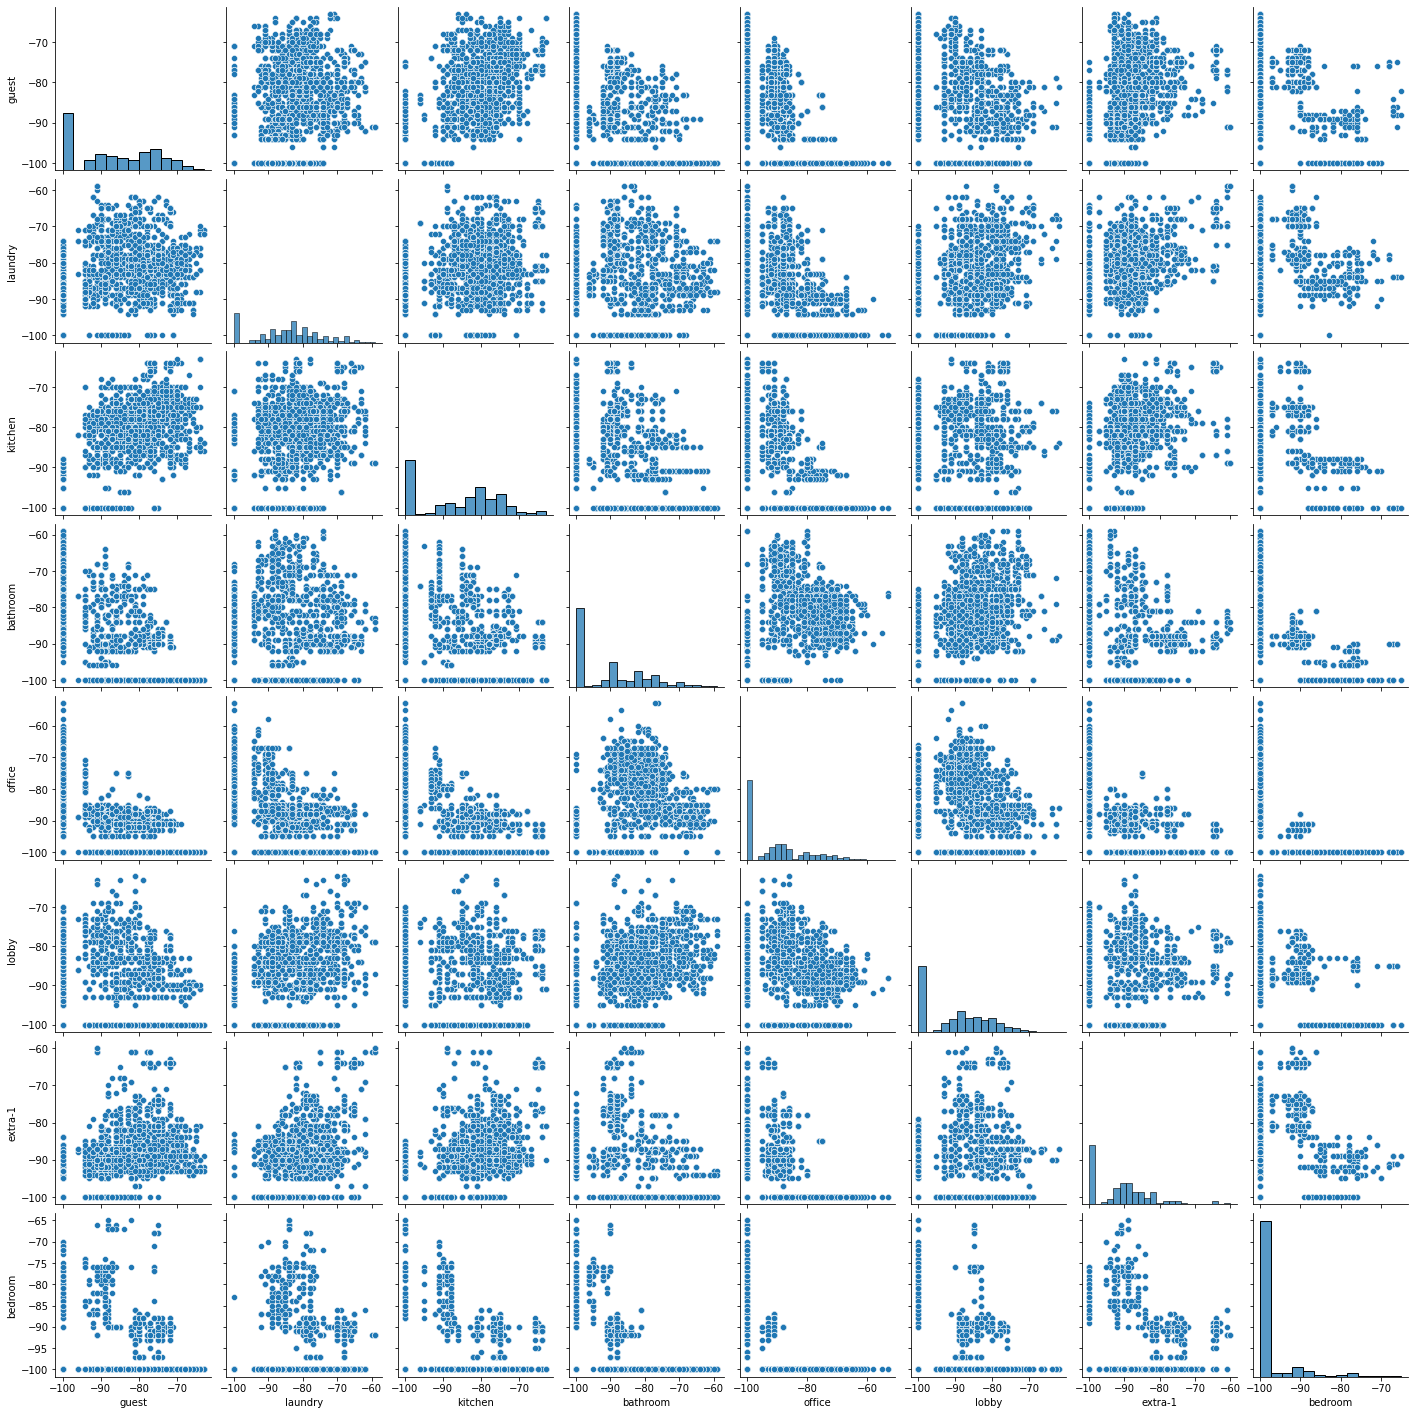

In [19]:
seaborn.pairplot(heartbeats_df)

In [20]:
estimator = multiclass.OneVsRestClassifier(
    linear_model.LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=0.003, max_iter=10000))
model_selection.cross_validate(estimator, X_train, y_train, cv=3, scoring=super_scoring)

{'fit_time': array([0.63780093, 0.60218763, 0.53101301]),
 'score_time': array([0.00740981, 0.00750828, 0.00724483]),
 'test_score': array([0.76629686, 0.68814038, 0.72400052])}

In [21]:
estimator = multiclass.OneVsRestClassifier(
    xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
model_selection.cross_validate(estimator, X_train, y_train, cv=3, scoring=super_scoring)

{'fit_time': array([0.23412418, 0.21709085, 0.22370148]),
 'score_time': array([0.01224184, 0.01175189, 0.01172113]),
 'test_score': array([0.89756267, 0.93899226, 0.97435992])}

In [22]:
estimator = xgboost.XGBClassifier(use_label_encoder=True, eval_metric='logloss')
model_selection.cross_validate(estimator, X_train, y_train, cv=5, scoring=super_scoring)

/home/artem/development/blackhole/mqtt-room-presence/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/artem/development/blackhole/mqtt-room-presence/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/hom

{'fit_time': array([0.17924857, 0.17774558, 0.24222565, 0.1732049 , 0.17306161]),
 'score_time': array([0.00453091, 0.00469685, 0.00462437, 0.00465083, 0.00469136]),
 'test_score': array([0.91749905, 0.90246938, 0.92480489, 0.97878886, 0.95779556])}

In [23]:
estimator = multiclass.OneVsRestClassifier(RandomForestClassifier(random_state=42, n_jobs=-1))
model_selection.cross_validate(estimator, X_train, y_train, cv=5, scoring=super_scoring)

{'fit_time': array([0.94214773, 0.5580616 , 0.5452373 , 0.56133342, 0.5460887 ]),
 'score_time': array([0.44602084, 0.42553592, 0.42570472, 0.42600513, 0.42275858]),
 'test_score': array([0.91749905, 0.90246938, 0.97878884, 0.97878886, 0.96679754])}

## Вывод
Похоже, что семейство алгоритмов на основе решающих деревьев работает лучше всего. Теперь попробуем найти лучшее разбиение сигналов.

In [25]:
testing_results = []

for period in [1]:
    for penalty in [0]:
        for off_on_delay in [113]:
            heartbeats_df = generate_heartbeats(period=period, penalty=penalty, off_on_delay=off_on_delay)
            heartbeats_target = heartbeats_df.room.values
            heartbeats_data = heartbeats_df.iloc[:, :-1]
            X_train, X_test, y_train, y_test = model_selection.train_test_split(heartbeats_data, heartbeats_target, 
                stratify=heartbeats_target, random_state=42)

            estimator = multiclass.OneVsRestClassifier(
                xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
            cross_val_score = model_selection.cross_validate(estimator, X_train, y_train, 
                cv=3, scoring=super_scoring)['test_score']
            estimator.fit(X_train, y_train)
            test_score = weighted_f_score(y_test, estimator.predict(X_test))

            testing_results.append({
                'period': period,
                'penalty': penalty,
                'off_on_delay': off_on_delay,
                'cross_val_score': cross_val_score,
                'test_score': test_score,
            })

Room  Bathroom
1 1623178273.571833 1623179027.036466
2 1623311318.973679 1623311662.605508
Room  Bedroom
3 1623309993.743202 1623311259.899672
Room  Guest
4 1623303335.43962 1623308842.114621
Room  Kitchen
5 1623179132.2141 1623180321.674042
Room  Laundry
6 1623309396.00721 1623309941.479975
Room  Lobby
7 1623177158.117678 1623178220.820064
Room  Office
8 1623174680.054884 1623176937.379279
9 1623311711.906418 1623313753.680922


In [ ]:
testing_results_df = pd.DataFrame(testing_results)
testing_results_df['cross_val_score'] = testing_results_df['cross_val_score'].apply(lambda x: x.mean())
testing_results_df['score'] = testing_results_df['cross_val_score'] + testing_results_df['test_score']
testing_results_df.sort_values(by='score', ascending=False, inplace=True)
testing_results_df[(testing_results_df['penalty'] > 0) | (testing_results_df['off_on_delay'] > 0)].head(20)

,period,penalty,off_on_delay,cross_val_score,test_score,score
11,1,0,113,0.928463,0.970305,1.898768
8,1,0,104,0.909653,0.974333,1.883986
6,1,0,98,0.923320,0.956332,1.879652
7,1,0,101,0.897749,0.974334,1.872083
10,1,0,110,0.898355,0.956508,1.854863
12,1,0,116,0.898946,0.954425,1.853372
2,1,0,86,0.891216,0.960258,1.851474
0,1,0,80,0.898010,0.950219,1.848229
3,1,0,89,0.895916,0.951074,1.846991
4,1,0,92,0.887861,0.955762,1.843623


In [ ]:
estimator = multiclass.OneVsRestClassifier(RandomForestClassifier(random_state=42, n_jobs=-1))
estimator.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(n_jobs=-1,
                                                     random_state=42))

In [ ]:
print('AUC ROC: ', metrics.roc_auc_score(y_test, estimator.predict_proba(X_test), multi_class='ovr'))
print('Precision: ', metrics.precision_score(y_test, estimator.predict(X_test), average=None))
print('Recall: ', metrics.recall_score(y_test, estimator.predict(X_test), average=None))

AUC ROC:  0.9999933858122843
Precision:  [0.98734177 1.         1.         1.         1.         1.
 1.        ]
Recall:  [1.         1.         1.         1.         1.         1.
 0.99537037]


## Исследование хертбитов
Получились довольно точные модели, как на кроссвалидации, так и на обучающей выборке. Даже подозрительно точные. Нужно проверить, все ли ладно с сгенерированными хертбитами.
1. Соблюден ли баланс классов в выборках?
2. Сигналы с каких сканеров присутствуют в зависимости от комнаты?

In [ ]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array(['Bathroom', 'Bedroom', 'Guest', 'Kitchen', 'Laundry', 'Lobby',
       'Office'], dtype=object), array([ 234,  179, 1049,  361,  110,  263,  649]))
(array(['Bathroom', 'Bedroom', 'Guest', 'Kitchen', 'Laundry', 'Lobby',
       'Office'], dtype=object), array([ 78,  60, 350, 121,  36,  88, 216]))


Выборка сбалансирована, с этим все хорошо

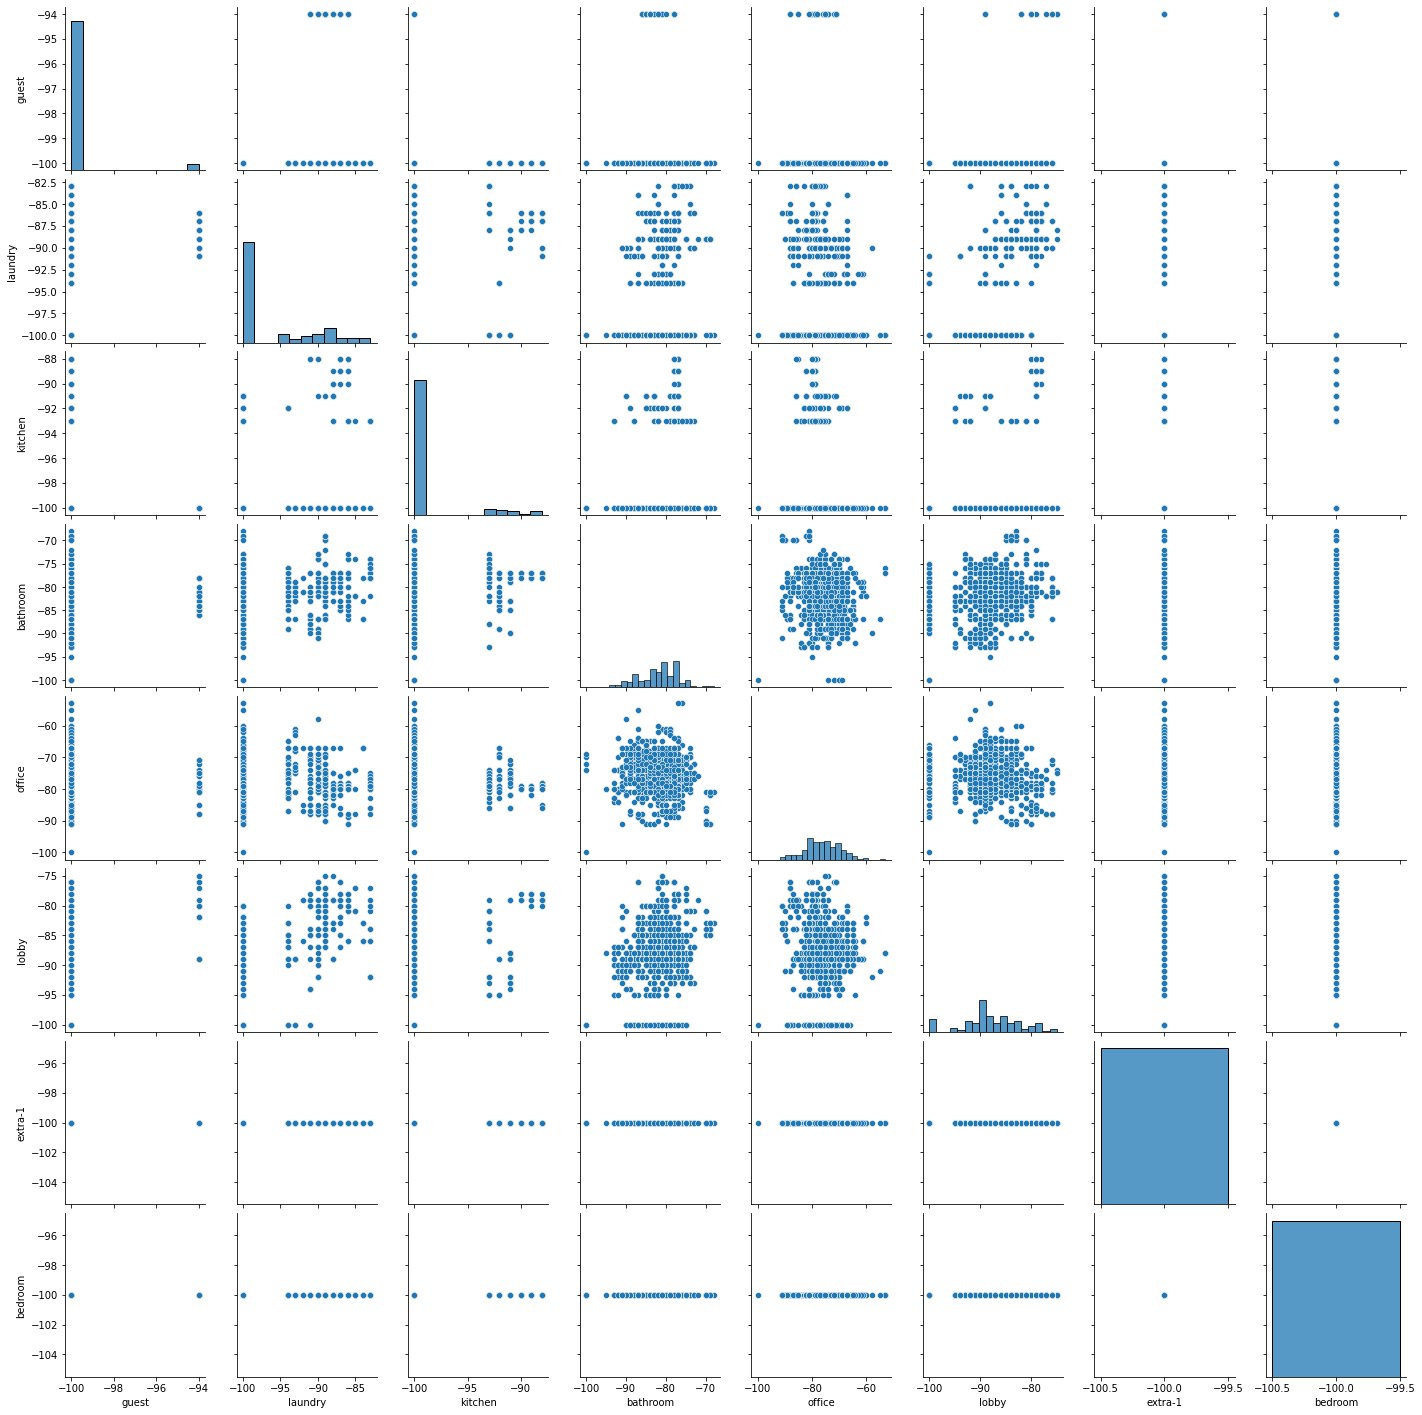

In [ ]:
seaborn.pairplot(heartbeats_df[heartbeats_df['room'] == 'Office'])

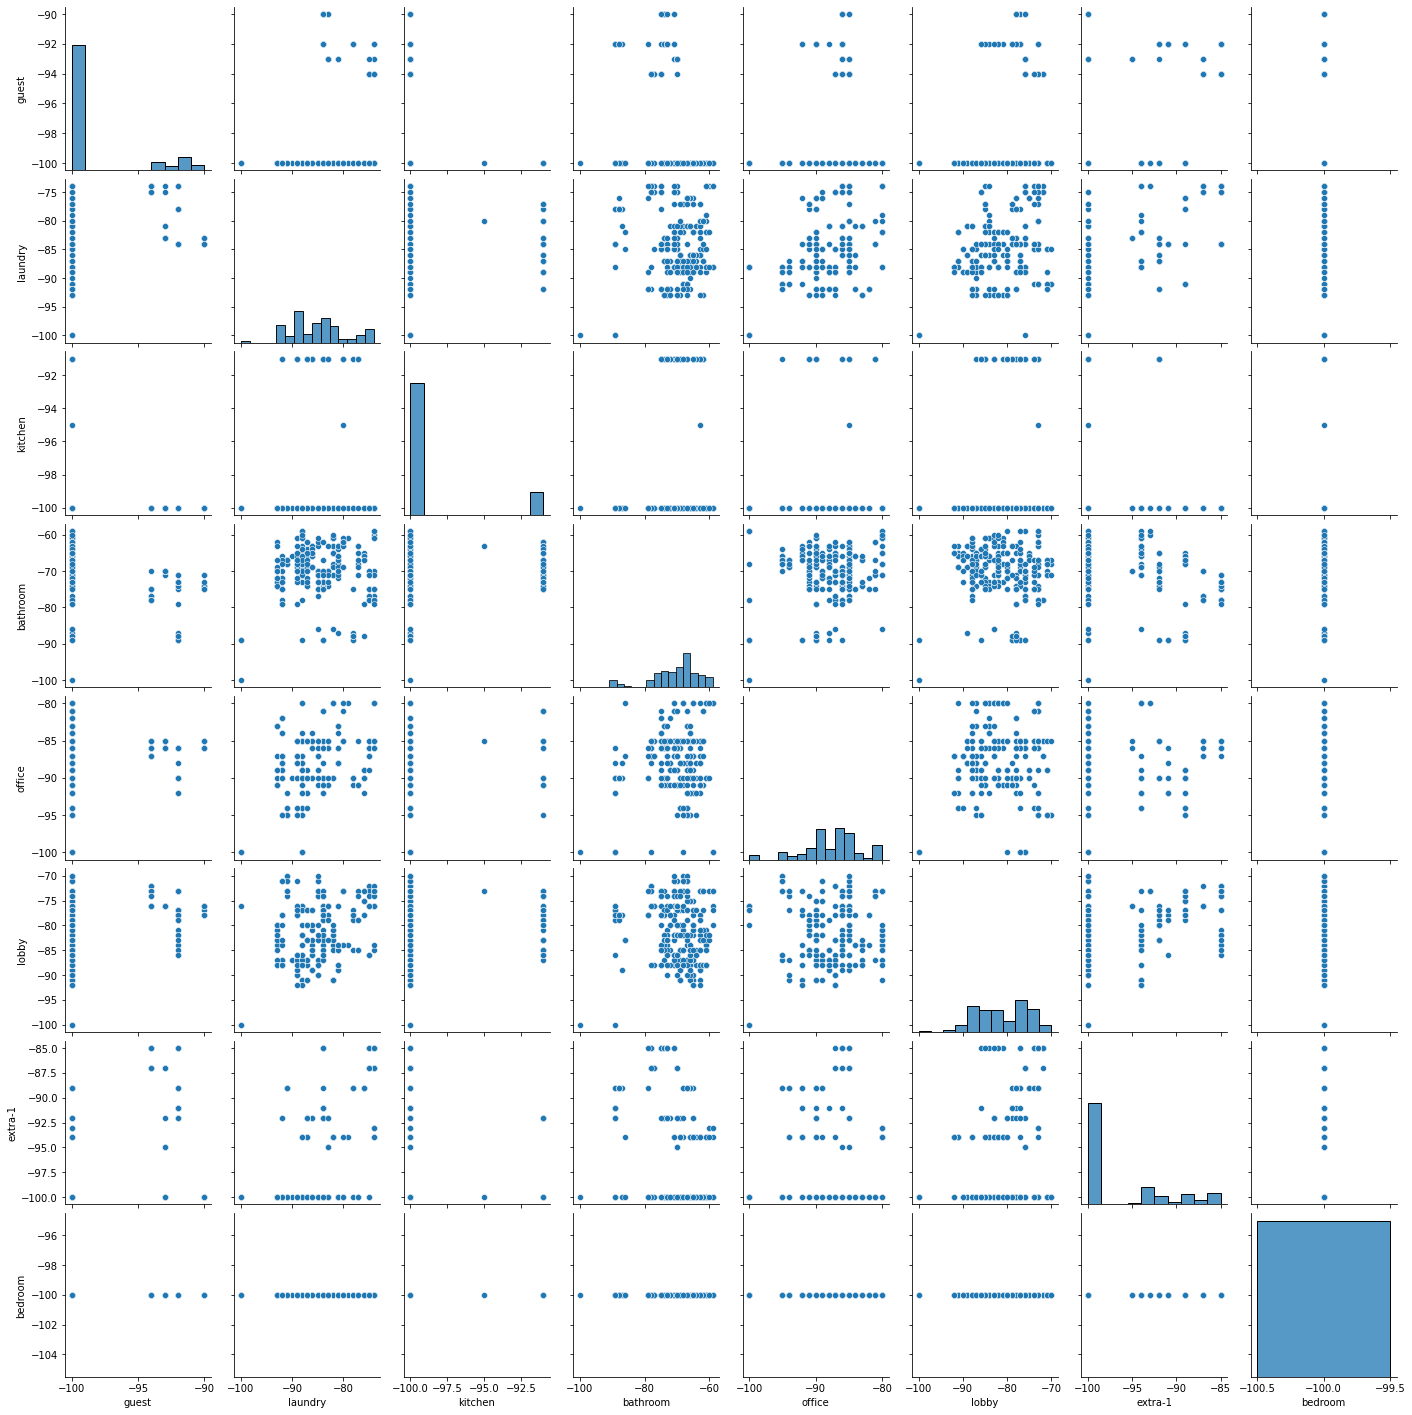

In [ ]:
seaborn.pairplot(heartbeats_df[heartbeats_df['room'] == 'Bathroom'])

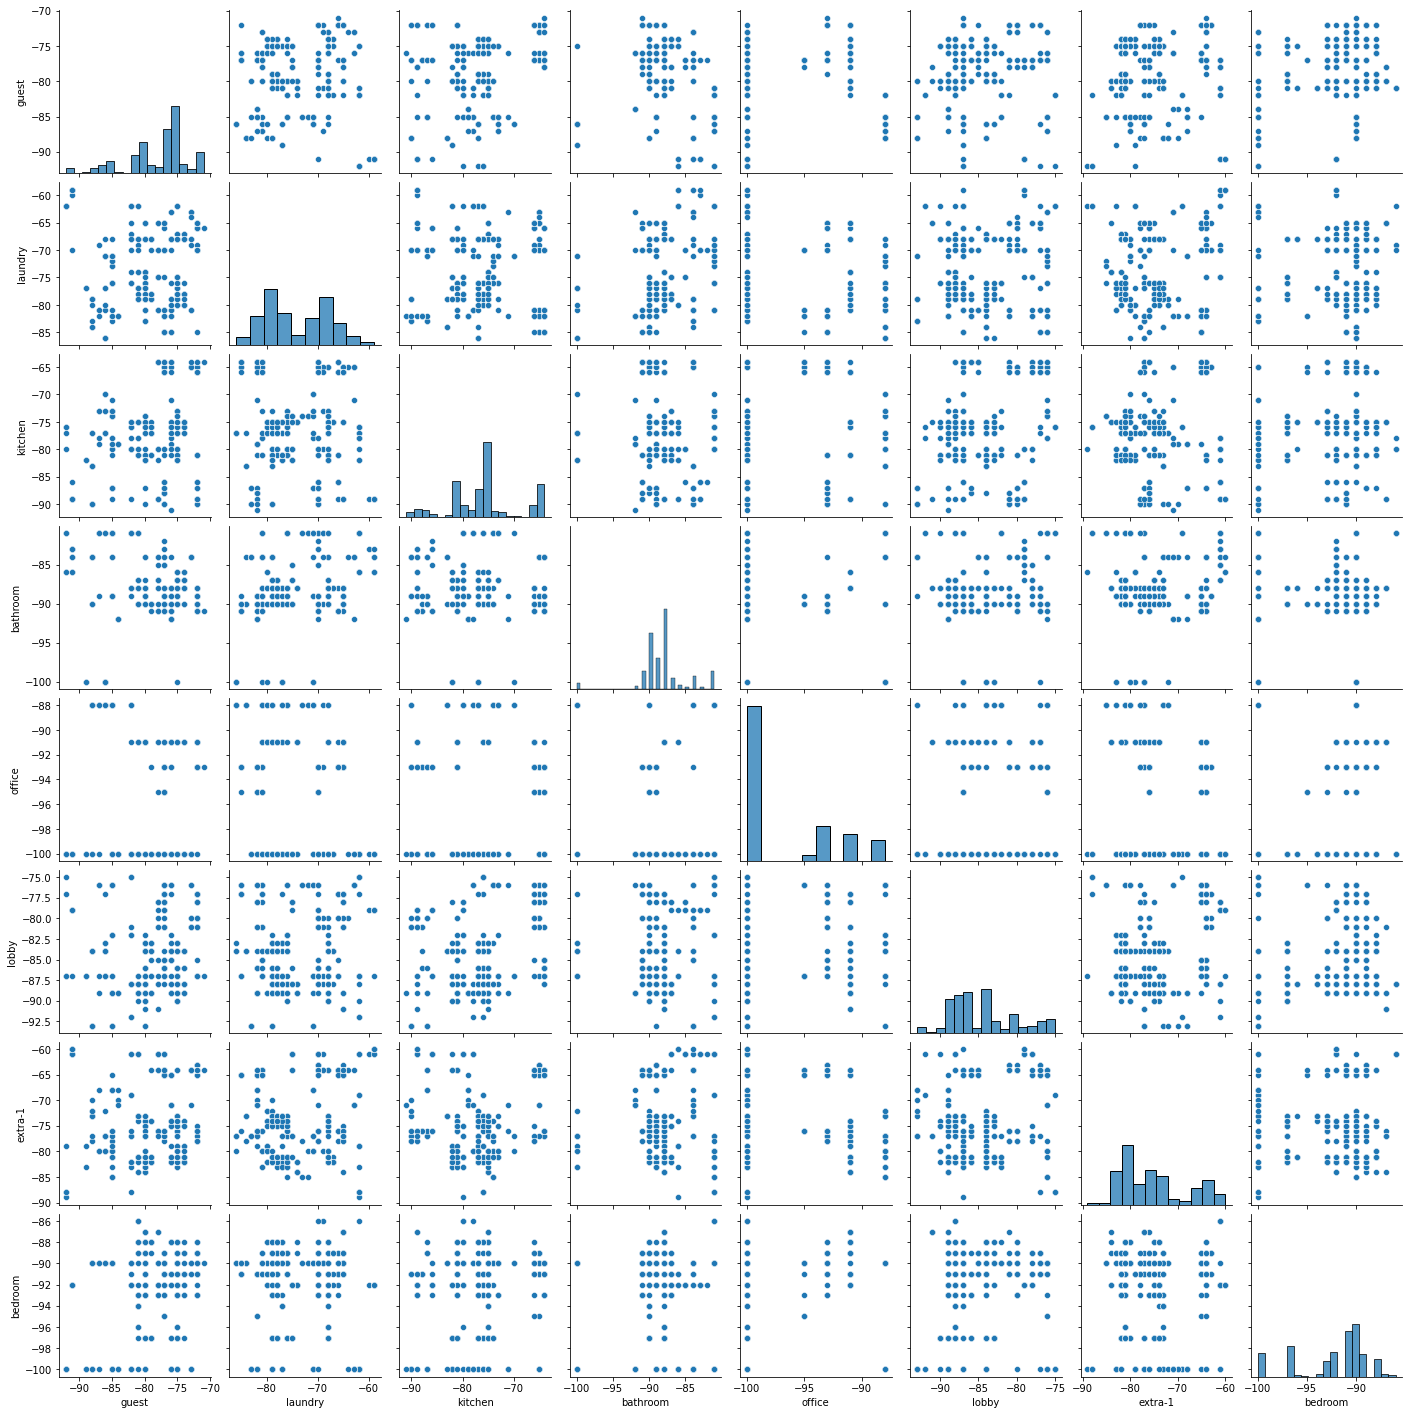

In [ ]:
seaborn.pairplot(heartbeats_df[heartbeats_df['room'] == 'Kitchen'])

In [ ]:
heartbeats_df[heartbeats_df['room'] == 'Office'].head(30)

,guest,laundry,kitchen,bathroom,office,lobby,extra-1,bedroom,room
10494,-100.0,-100.0,-100.0,-82.0,-71.0,-100.0,-100.0,-100.0,Office
10496,-100.0,-100.0,-100.0,-81.0,-71.0,-100.0,-100.0,-100.0,Office
10500,-100.0,-100.0,-100.0,-81.0,-74.0,-100.0,-100.0,-100.0,Office
10507,-100.0,-100.0,-100.0,-81.0,-70.0,-100.0,-100.0,-100.0,Office
10523,-100.0,-100.0,-100.0,-81.0,-71.0,-89.0,-100.0,-100.0,Office
10527,-100.0,-100.0,-100.0,-85.0,-71.0,-89.0,-100.0,-100.0,Office
10529,-100.0,-100.0,-100.0,-85.0,-73.0,-89.0,-100.0,-100.0,Office
10530,-100.0,-100.0,-100.0,-85.0,-73.0,-88.0,-100.0,-100.0,Office
10532,-100.0,-100.0,-100.0,-76.0,-73.0,-88.0,-100.0,-100.0,Office
10540,-100.0,-100.0,-100.0,-76.0,-72.0,-88.0,-100.0,-100.0,Office


Данные выглядят вполне правдоподобно. В разных комнатах преобладают данные с ближайших к комнате сканеров, сигналы с отдаленных сканеров близки к отсутствующему сигналу (-100). 

# Результат испытаний
После испытания модели выяснилось, что ее генеративная способность невысока (наблюдались ошибки даже в простых сценариях), а адаптация ответа к изменению положения устройства происходит длительное время и с ошибками. 
Идеи что делать дальше:
1. На модель слишком большой вклад оказывает информация со сканеров, находящихся в других (далеких) комнатах, в итоге ответ модели слишком сильно зависит от параметра off on delay (перевод сигнала со сканера на "отсутствует" после N секунд). Возможно имеет смысл использовать только часть сканеров для определения положения в конкретных комнатах.
2. Хороший результат на кросс-валидации вероятно достигается засчет похожести эелементов выборки. Зачастую разница между двумя соседними хертбитами есть только в одном признаке из 8, возможно причина в этом. Если генерировать хертбиты с большей задержкой, то и данные получаются более различные в соседних хертбитах (так как за больший период приходит больше данных с разных сканеров) и результат работы моделей ухудшается. Вероятно понижение размерности задачи для каждой комнаты в отдельности позволит улучшить работу модели
3. Также понижение размерности позволит быстрее реагировать на изменение положения устройства.
4. Насчет положения устройства. Данные собирались по каждой комнате в отдельности, хотя на практике устройство перемещается из комнаты в комнату. Генерируемые хертбиты никак не отражают изменчивость положения устройства между комнатами, следовательно в моделях никак не учитывается скорость регирования модели на изменения положения. Возможно сгенерировав хертбиты путем "путешествия" устройства по разным комнатам поможет учитывать и эту особенность в модели.

Отсюда план дальнейшего исследования:
1. Генерировать хертбиты путем имитации перемещения устройства из комнаты в комнату
2. Своя реализация OneVsRestClassifier, которая будет сначала отбирать признаки для обучения (напримре l1 регуляризацией линейной модели), затем обучать переданнй алгоритм именна на этом подмножестве признаков.
3. Разработать метод испытания модели, чтобы количественно оценивать работу моделей на практике, сейчас оценка ведется по субъективным ощущениям.

In [187]:
estimator = pipeline.Pipeline([
    ('scale_features', preprocessing.StandardScaler()),
    ('feature_selection', feature_selection.RFECV(
        linear_model.LogisticRegression(penalty='l1', C=0.01, class_weight='balanced', solver='liblinear'),
        min_features_to_select=1, scoring='recall', cv=3)),
    ('classification', xgboost.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

heartbeats_df = generate_heartbeats(period=2, penalty=5, kalman_R=0.5, kalman_Q=10)
heartbeats_target_guest = [1 if r == 'Guest' else 0 for r in heartbeats_df.room.values]
heartbeats_data_guest = heartbeats_df.iloc[:, :-1]
X_train_guest, X_test_guest, y_train_guest, y_test_guest = model_selection.train_test_split(
    heartbeats_data_guest, heartbeats_target_guest, stratify=heartbeats_target_guest, random_state=42)

estimator.fit(X_train_guest, y_train_guest)

print(list(zip(heartbeats_data_guest.columns, estimator.named_steps['feature_selection'].get_support())))

# print('AUC ROC: ', metrics.roc_auc_score(y_test_guest, estimator.predict_proba(X_test_guest)))
print('Precision: ', metrics.precision_score(y_test_guest, estimator.predict(X_test_guest)))
print('Recall: ', metrics.recall_score(y_test_guest, estimator.predict(X_test_guest)))

Room  Bathroom
Room  Bedroom
Room  Guest
Room  Kitchen
Room  Laundry
Room  Lobby
Room  Office
[('guest', False), ('laundry', False), ('kitchen', False), ('bathroom', True), ('office', False), ('lobby', False), ('extra-1', False), ('bedroom', False)]
Precision:  0.0
Recall:  0.0


/home/artem/development/blackhole/mqtt-room-presence/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
